# Home Assignment 4

Submit your solutions in teams of 3-4 students. Unless explicitly agreed otherwise in advance, **submissions from teams with more or less members will NOT be graded**. Submit only one notebook per team. Only submit a notebook, do not submit the dataset(s) you used. Also, do NOT compress/zip your submission!

You may use the code from the exercises and basic functionalities that are explained in official documentation of Python packages without citing, __all other sources must be cited__. In case of plagiarism (copying solutions from other teams or from the internet) ALL team members may be expelled from the course without warning.

#### General guidelines:
* Make sure that your code is executable, any task for which the code does not directly run on our machine will be graded with 0 points.
* If you use packages that are not available on the default or conda-forge channel, list them below. Also add a link to installation instructions. 
* Ensure that the notebook does not rely on the current notebook or system state!
  * Use `Kernel --> Restart & Run All` to see if you are using any definitions, variables etc. that 
    are not in scope anymore.
  * Do not rename any of the datasets you use, and load it from the same directory that your ipynb-notebook is located in, i.e., your working directory.
* Make sure you clean up your code before submission, e.g., properly align your code, and delete every line of code that you do not need anymore, even if you may have experimented with it. Minimize usage of global variables. Avoid reusing variable names multiple times!
* Ensure your code/notebook terminates in reasonable time.
* Feel free to use comments in the code. While we do not require them to get full marks, they may help us in case your code has minor errors.
* For questions that require a textual answer, please do not write the answer as a comment in a code cell, but in a Markdown cell below the code. Always remember to provide sufficient justification for all answers.
* You may create as many additional cells as you want, just make sure that the solutions to the individual tasks can be found near the corresponding assignment.
* If you have any general question regarding the understanding of some task, do not hesitate to post in the student forum in Ilias, so we can clear up such questions for all students in the course.

Additional packages (if any):
 - `copy`, https://docs.python.org/3/library/copy.html

In [8]:
# general imports may go here!
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from typing import List, Optional, Tuple, Dict
import copy

### Task 1:  Simulating the SIS-Model on Random Graphs (25 pts)


#### a) Implementing the SIS Model (10 pts)

Implement a function that models one timestep of the spreading according to the SIS model. Use the signature specified in the cell below! Do not modify the original input network. Avoid unnecessary steps, such as setting the infected state twice.

In [10]:
def spread_SIS(G: nx.Graph, beta: float, mu: float, att: str = "state") -> nx.Graph:
    """
    :param G: input networkx graph (nodes have an attribute specified by `att` indicating infection state)
    :param beta: probability that an infected individual infects one of their neighbors
    :param mu: probability that an infected individual recovers
    :param att: name of the node attribute indicating infection status (0: susceptible, 1: infected)
    :return: a new networkx graph after one timestep of the SIS process
    """
    # Create a deep copy to avoid modifying the original graph
    new_G = copy.deepcopy(G)

    # First pass: determine recovery
    for node in G.nodes:
        if G.nodes[node][att] == 1:
            # Infected individual may recover
            if random.random() < mu:
                new_G.nodes[node][att] = 0

    # Second pass: determine infections
    for node in G.nodes:
        if G.nodes[node][att] == 0:
            # Susceptible individual may be infected by neighbors
            for neighbor in G.neighbors(node):
                if G.nodes[neighbor][att] == 1:
                    if random.random() < beta:
                        new_G.nodes[node][att] = 1
                        break  # No need to check other neighbors once infected

    return new_G

#### b) Simulating the Spread (15 pts)

Create two networks, one Barabasi-Albert network, and one Erdos-Renyi network, both with 100 nodes and average degree $\langle k \rangle = 4$. Initialize both networks by (i) reducing the network to its biggest component, and (ii) setting one randomly chosen node to infected. For that purpose, create a node attribute called ```'state'```, which takes the value `0` if the corresponding individual is susceptible, and `1` otherwise. Save the resulting initial graphs into variables ``ER0`` for the initial Erdos-Renyi graph, and ``BA0`` for the initial Barabasi-Albert network.   
For both networks, apply your implementation from a) with fixed value $\mu = 0.8$, and varied $\beta\in \{0.1,0.2,\dots,0.9,1 \}$ to simulate 50 timesteps of the spreading according to the SIS model. More precisely, for each value of $\beta$, run one simulation per graph model of these 50 timesteps, starting at the initial graphs ``ER0`` and ``BA0``.  
Plot the relative share of infected nodes in the graph over all timesteps, using one plot per graph model which includes all curves for the varied values of $\beta$.  
Provide some explanation and interpretation regarding the effect of varying $\beta$, as well as on the differences between both graph models in cell __A1b)__!

In [11]:
n = 100
avg_k = 4

# For ER: p = avg_k / (n - 1)
p = avg_k / (n - 1)
ER = nx.erdos_renyi_graph(n, p)

# For BA: m = avg_k / 2 (since each new node makes m edges)
m = avg_k // 2
BA = nx.barabasi_albert_graph(n, m)

# Keep only the largest connected component
ER = ER.subgraph(max(nx.connected_components(ER), key=len)).copy()
BA = BA.subgraph(max(nx.connected_components(BA), key=len)).copy()


In [12]:
def initialize_graph(G):
    for node in G.nodes:
        G.nodes[node]["state"] = 0
    infected = random.choice(list(G.nodes))
    G.nodes[infected]["state"] = 1
    return G

ER0 = initialize_graph(ER.copy())
BA0 = initialize_graph(BA.copy())

In [13]:
timesteps = 50
mu = 0.8
betas = [round(b, 1) for b in np.arange(0.1, 1.01, 0.1)]

def simulate(G0, model_name):
    results = {}
    for beta in betas:
        G = G0.copy()
        infected_share = []
        for t in range(timesteps):
            infected_count = sum(nx.get_node_attributes(G, "state").values())
            infected_share.append(infected_count / G.number_of_nodes())
            G = spread_SIS(G, beta, mu, att="state")
        results[beta] = infected_share
    return results

ER_results = simulate(ER0, "ER")
BA_results = simulate(BA0, "BA")


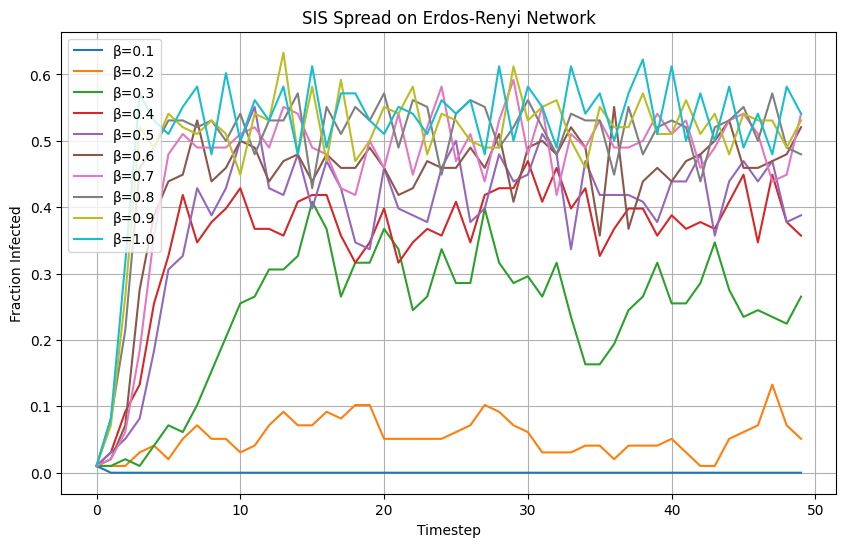

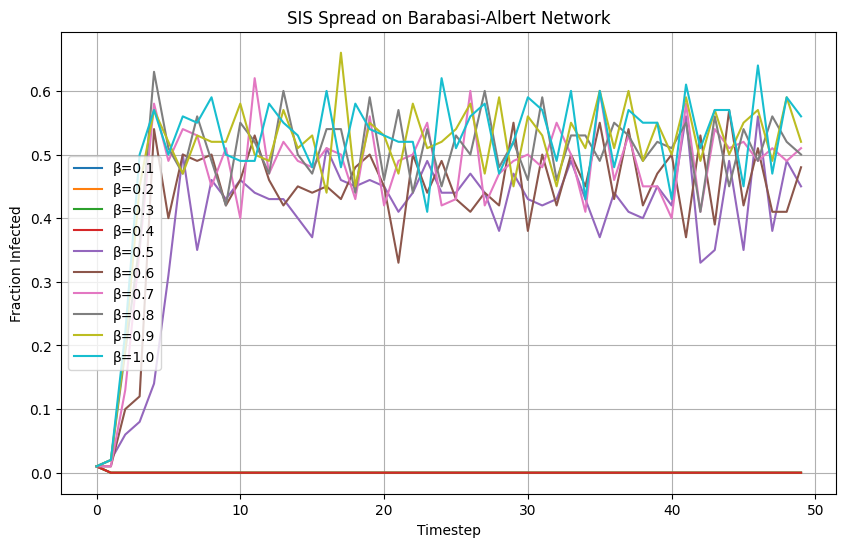

In [14]:
def plot_results(results, title):
    plt.figure(figsize=(10, 6))
    for beta, infection_curve in results.items():
        plt.plot(infection_curve, label=f"β={beta}")
    plt.xlabel("Timestep")
    plt.ylabel("Fraction Infected")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_results(ER_results, "SIS Spread on Erdos-Renyi Network")
plot_results(BA_results, "SIS Spread on Barabasi-Albert Network")


**A1b):** 
As we increase β, the chance of the infection spreading goes up. When β is low, the infection often dies out fast—especially because recovery (μ = 0.8) is so strong. But as β gets higher, the infection sticks around longer and affects more of the network.

In the Barabási–Albert (BA) network, the infection spreads more easily and stabilizes at a higher level. That’s because a few highly connected nodes (hubs) keep passing it around, making it hard to die out.

In the Erdős–Rényi (ER) network, the infection struggles more when β is low, and even when β increases, the spread is slower and less stable.

So basically, higher β = more infection, and the network structure really matters—BA networks make it easier for diseases to spread and stay.